In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os

In [6]:
# Step 1: Define paths and parameters
data_dir = './dataset-resized'  # Replace with the path to your dataset
categories = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
img_size = (128, 128)
batch_size = 32

# Step 2: Data Augmentation and Preprocessing
data_gen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values
    rotation_range=40,  # Random rotation
    width_shift_range=0.2,  # Horizontal shift
    height_shift_range=0.2,  # Vertical shift
    shear_range=0.2,  # Shear transformation
    zoom_range=0.2,  # Random zoom
    horizontal_flip=True,  # Horizontal flipping
    fill_mode='nearest',
    validation_split=0.2  # 20% data for validation
)

train_data = data_gen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_data = data_gen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Step 2.1: Compute Class Weights
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_labels = train_data.classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(class_labels),
    y=class_labels
)

class_weights = dict(enumerate(class_weights))


Found 2024 images belonging to 6 classes.
Found 503 images belonging to 6 classes.


In [7]:
# Step 3: Build the Model using Transfer Learning
base_model = tf.keras.applications.MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
base_model.trainable = True  # Freeze base layers

# Freeze earlier layers, fine-tune only the last 50 layers
for layer in base_model.layers[:-50]:
    layer.trainable = False


model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(0.6),
    Dense(len(categories), activation='softmax')
])

# Step 4: Compile the Model
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001,  # Lower learning rate for fine-tuning
    decay_steps=10000,
    decay_rate=0.9
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Epoch 1/50


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


64/64 ━━━━━━━━━━━━━━━━━━━━ 15s 145ms/step - accuracy: 0.2827 - loss: 4.4259 - val_accuracy: 0.4155 - val_loss: 3.7574
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - accuracy: 0.5252 - loss: 3.4676 - val_accuracy: 0.3897 - val_loss: 3.9205
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - accuracy: 0.6805 - loss: 3.1295 - val_accuracy: 0.3857 - val_loss: 4.0840
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - accuracy: 0.7049 - loss: 2.9819 - val_accuracy: 0.4354 - val_loss: 3.9417
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 9s 141ms/step - accuracy: 0.7358 - loss: 2.8371 - val_accuracy: 0.4751 - val_loss: 3.7085
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 0.7672 - loss: 2.6962 - val_accuracy: 0.4930 - val_loss: 3.6931
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 0.7794 - loss: 2.5815 - val_accuracy: 0.5368 - val_loss: 3.4118
Epoch 8/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - accuracy: 0.8140 - loss: 2.4756 - val_accuracy: 0.5706 - val

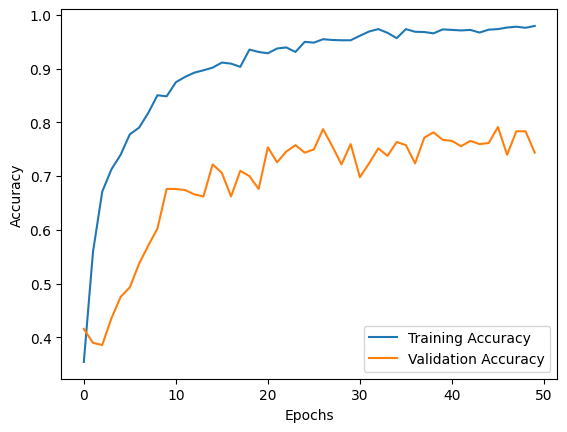

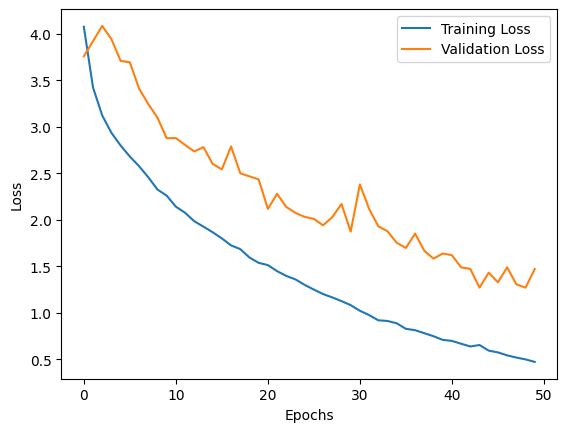

In [8]:
# Step 5: Train the Model
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    train_data,
    epochs=50,
    validation_data=val_data,
    callbacks=[early_stopping],
    class_weight=class_weights  # Apply class weights
)

# Step 6: Save the Model
model.save('./waste_classification_model.h5')

# Step 7: Evaluate the Model
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Step 8: Test the Model (Optional)
def predict_image(image_path):
    from tensorflow.keras.utils import load_img, img_to_array
    import numpy as np

    img = load_img(image_path, target_size=img_size)  # Load image with specified size
    img_array = img_to_array(img) / 255.0  # Normalize the image
    img_array = tf.expand_dims(img_array, 0)  # Expand dimensions to match model input
    
    predictions = model.predict(img_array)  # Get predictions
    class_idx = tf.argmax(predictions[0]).numpy()  # Get class index
    class_label = categories[class_idx]  # Map to class label
    return class_label

# Test with a sample image
sample_image_path = './dataset-resized/cardboard/cardboard254.jpg'  # Replace with an actual image path
print("Predicted Class:", predict_image(sample_image_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 715ms/step
Predicted Class: cardboard
